In [1287]:
import numpy
from data.data_utils import load_dataset



In [1288]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.linalg import svd
from pdb import set_trace

# Q1 K-NN for Regression

In [1289]:
np.random.seed(42)

## Useful functions

In [1290]:
# Get RMSE
def RMSE(y, y_hat):
  return np.sqrt(np.mean(np.square(y-y_hat)))

In [1291]:
def knn_regressor(x_train, y_train, x_test, k = 1, metric = "minkowski_2") -> np.array:
    """
    Find the k-th closest data points along x axis and take the average of their y values.
    Do that for all testing data and return the predicted y values.
    """
    y_test = np.zeros((x_test.shape[0], 1))
    # print(y_test.shape)
    for i, x_test_i in enumerate(x_test):
        if metric == "minkowski_2":
          dist = np.sqrt(np.sum(np.square(x_train - x_test_i.reshape((1,-1))), axis = 1))
        elif metric == "minkowski_1":
          dist = np.sum(np.abs(x_train - x_test_i.reshape((1,-1))), axis = 1)
        else:
            pass
        i_nn = np.argpartition(dist, kth=k)[:k]
        # k=5: i_nn=[122 384  90 399  40] etc
        # compute the mean of these nearest neighbours
        y_test[i,0] = np.mean(y_train[i_nn, 0])
    # y_test: [[mean y for x_test_1], [mean y for x_test_2], [mean y for x_test_3]] ...
    return y_test

def knn_cross_validation(x, y, dataset, metrics, v = 5) -> np.array:
    """
    Cross validation to find the y_test,
    Return k_vals, best, fold_i[np.argmin(best)], k_merged_prediction
    k_vals : list of all k we tried
    best : list of lowest RMSE for each k values
    fold_i[np.argmin(best)] : the fold index with the lowest RMSE value
    k_merged_prediction : predictions merged from cross-validation for each k value
    """
    # Create shuffling indices for training data
    n = x.shape[0]

    # Initialize mrse returned array
    rmse = []
    # rmse[:] = np.nan
    # print(type(mrse))
    if dataset == "mauna_loa" and metrics == "minkowski_2": # plot the training data in the first figure
        plt.figure(figsize=(10,7))
        plt.plot(x.squeeze(), y.squeeze(), 'k', label='Exact', alpha=0.5)

    # Create random k value
    min_k = dict(rosenbrock=1,  pumadyn32nm=22, mauna_loa=1)  # specify minimum k value to consider in the search
    max_k = dict(rosenbrock=10, pumadyn32nm=26, mauna_loa=30) # specify maximum k value to consider in the search
    # Define a range of k
    k_vals = np.arange(min_k[dataset], max_k[dataset]+1, dtype=int)
    # print(k_vals)
    
    # print("predictions", predictions.shape)
    for k in k_vals:
        predictions = np.zeros(x.shape[0])
        # predictions[:] = np.nan
        val_err_in_fold = []
        # val_err_in_fold[:] = np.nan
        five_fold = np.array([0,1,2,3,4])
        idx_cv = np.ones(x.shape[0])
        idx_cv = np.arange(x.shape[0], dtype=int)
        idx_cv = np.random.permutation(idx_cv)
        idx_cv = np.array_split(idx_cv, 5)
        for i_split in range(v):
            train_fold = np.delete(five_fold, i_split)
            # print("train_fold", train_fold)
            split_train = np.concatenate([idx_cv[i] for i in train_fold])
            split_valid = idx_cv[i_split]
            # print("len:", len(split_train), len(split_valid))
            x_valid = x[split_valid]
            # print("split valid", len(split_valid))
            # print("y", y.shape)
            y_valid = y[split_valid]
            # print("split valid", split_valid)
            # print("split train", split_train)
            # print("x", x[split_train])
            predictions[split_valid] = knn_regressor(x_train=x[split_train], y_train=y[split_train], 
                                                        x_test=x_valid, k=k, metric=metrics).squeeze()
            val_err = RMSE(y=y_valid.squeeze(), y_hat=predictions[split_valid])
            val_err_in_fold.append(val_err)
        # print("k", k, val_err_in_fold)
        rmse.append(val_err_in_fold)
        if dataset == 'mauna_loa' and k in [2, 22] and metrics == "minkowski_2":
            plt.plot(x.squeeze(), predictions, label='k=%d validation prediction'%k)
            # plt.legend(loc=0)
            plt.xlabel("date")
            plt.ylabel("CO2")
            plt.legend(loc=0)
            plt.title("Mauna Loa Cross-validation predictions (Minkowski 2)")
    print("mse", np.asarray(rmse))
    rmse = np.asarray(rmse)
    fold_i = rmse.argmin(axis=1)
    best = rmse.min(axis=1)
    # print("best",best)
    return k_vals, best, fold_i[np.argmin(best)]

## Mauna Loa

In [1292]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
# Merge splits
x = np.vstack([x_valid, x_train])
y = np.vstack([y_valid, y_train])

mse [[0.04608724 0.0462502  0.04998823 0.04692291 0.04954062]
 [0.03237923 0.03122924 0.03556202 0.03073705 0.02968649]
 [0.04426705 0.04027289 0.04430361 0.037225   0.04225171]
 [0.05422249 0.05168819 0.04818242 0.04782466 0.04520066]
 [0.05818662 0.05409331 0.05419306 0.05706816 0.05307202]
 [0.06341893 0.05997868 0.06550187 0.06333839 0.06865091]
 [0.07451087 0.07134256 0.071111   0.07554188 0.0708126 ]
 [0.08232392 0.07499058 0.07828805 0.07872406 0.08014423]
 [0.08274614 0.08456883 0.0820914  0.08725802 0.08162082]
 [0.08942203 0.09128102 0.08680712 0.08710542 0.09423433]
 [0.09130479 0.09148154 0.08889828 0.09492352 0.09450568]
 [0.08900532 0.0998073  0.09220602 0.09795691 0.09228048]
 [0.09959781 0.091223   0.09568883 0.09452868 0.09205447]
 [0.08941943 0.09172185 0.08925988 0.09929636 0.09501751]
 [0.08850852 0.09565855 0.0916911  0.08803442 0.08924397]
 [0.09196165 0.08655269 0.08773815 0.09052118 0.08492032]
 [0.08295654 0.08569297 0.08761795 0.08730678 0.08520516]
 [0.082923

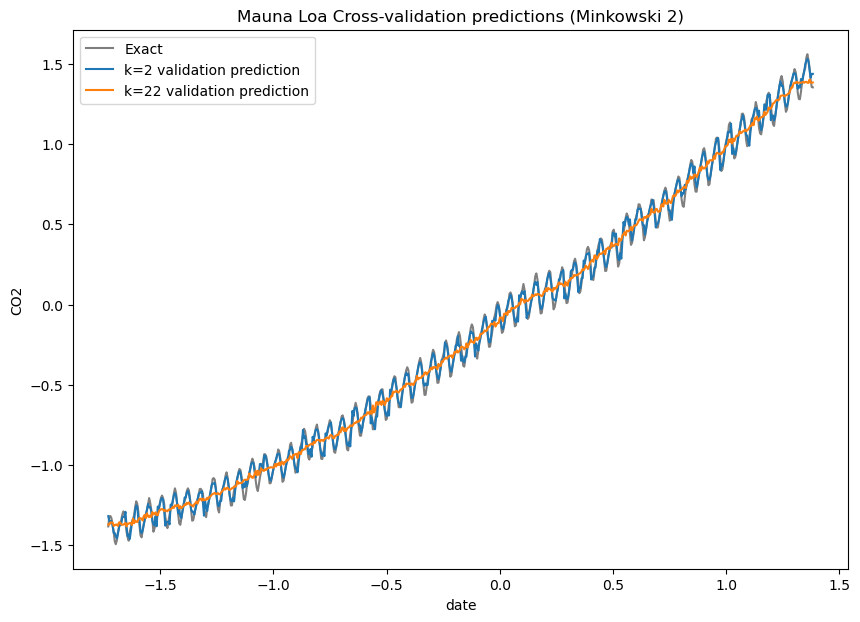

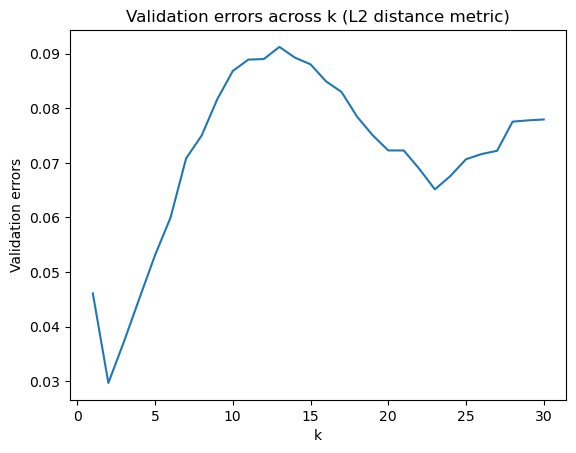

In [1293]:
k_vals, best2, fold_2 = knn_cross_validation(x, y, "mauna_loa", v = 5, metrics = "minkowski_2")

plt.figure()
plt.title('Validation errors across k (L2 distance metric)')
plt.xlabel('k')
plt.ylabel('Validation errors')
plt.plot(k_vals, best2)

# print(k_vals,best2,fold_2)


In [1294]:
# rmse = [[1,2,3],[4,5,6]]
# rmse_max = [max(r) for r in rmse]
# rmse_max

mse [[0.04965546 0.04994537 0.04839429 0.04827816 0.04375707]
 [0.03275351 0.02967934 0.03952228 0.03228555 0.03437096]
 [0.04285269 0.04029225 0.04575858 0.04262125 0.04051047]
 [0.04607289 0.04501695 0.05256528 0.04291441 0.04720072]
 [0.05371791 0.05382982 0.05832135 0.06034516 0.05555456]
 [0.06606007 0.05967822 0.06264027 0.06483678 0.0594834 ]
 [0.07253511 0.06369537 0.06716613 0.07378775 0.07617601]
 [0.08047037 0.07853913 0.0788158  0.07669573 0.08239915]
 [0.08400724 0.08669541 0.08631652 0.08702379 0.08395733]
 [0.08721227 0.09187752 0.08426622 0.09037824 0.09119139]
 [0.09564883 0.09484707 0.08856315 0.08707565 0.09428135]
 [0.08820619 0.09360286 0.09223037 0.09434211 0.09497461]
 [0.09491152 0.09492427 0.09317558 0.09444976 0.09294971]
 [0.09263173 0.0910402  0.09372319 0.09330995 0.09149594]
 [0.09294403 0.08979331 0.09391223 0.09113409 0.0929134 ]
 [0.08716506 0.08858891 0.08418238 0.08479637 0.09186906]
 [0.08731904 0.08324116 0.08115842 0.08449704 0.08175297]
 [0.081180

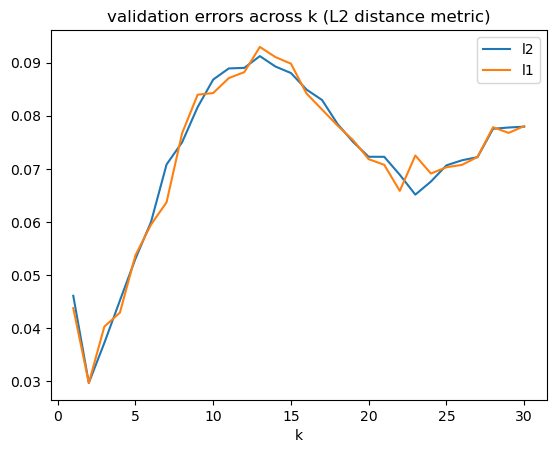

In [1295]:
_, best1, fold_1 = knn_cross_validation(x, y, "mauna_loa", v = 5, metrics = "minkowski_1")
# best = [ err * 30 ]
# Show validation errors for both metrics
plt.figure()
plt.title('validation errors across k (L2 distance metric)')
plt.xlabel('k')
plt.plot(k_vals, best2, label = "l2")
plt.plot(k_vals, best1, label = "l1")
plt.legend()
plt.show()

In [1296]:
def report(x, y, x_test, y_test, best1, best2):
    idx1 = np.argmin(best1)
    idx2 = np.argmin(best2)
    p = np.argmin([best1[idx1], best2[idx2]]) + 1
    if p == 2:
        k_best = idx2+1
        print("Metric Minkowski with p = %d at k = %d's %dth fold has the lowest validation error %f." %(p, k_best, fold_2+1, best2[idx2]))
    else:
        k_best = idx1+1
        print("Metric Minkowski with p = %d at k = %d's %dth fold has the lowest validation error %f." %(p, k_best, fold_1+1, best1[idx1]))

    # Find test error
    def k_nn_test_error(x_train, y_train, x_test, y_test, k, metric) -> np.array:
        predictions = knn_regressor(x_train = x_train, y_train = y_train, 
                                    x_test = x_test, k = k, metric = metric).squeeze()
                # print(predictions)
                # print("dim valid", y_valid.squeeze().shape)
                # print("dim pred", predictions.shape)
        test_err = RMSE(y=y_test.squeeze(), y_hat=predictions)
        
        return predictions, test_err
    m_best = "minkowski_" + str(p)
    predictions, test_err = k_nn_test_error(x, y, x_test, y_test, k = k_best, metric = m_best)
    print("The test error for the best model is: %f" %(test_err))
report(x, y, x_test, y_test, best1, best2)



Metric Minkowski with p = 1 at k = 2's 2th fold has the lowest validation error 0.029679.
The test error for the best model is: 0.440705


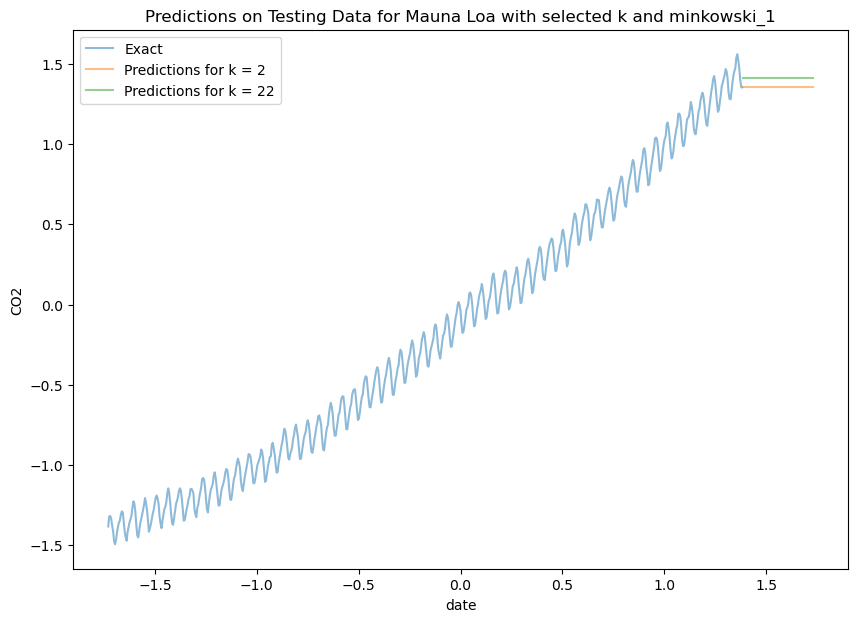

In [1297]:
# Plot Prediction Curves for several k values
y_test_pred_2 = knn_regressor(x, y, x_test, k = 2, metric = m_best)
y_test_pred_22 = knn_regressor(x, y, x_test, k = 22, metric = m_best)

plt.figure(figsize=(10,7))
plt.title('Predictions on Testing Data for Mauna Loa with selected k and %s'%(m_best))
plt.ylabel('CO2')
plt.xlabel('date')
plt.plot(x.squeeze(), y.squeeze(), label='Exact', alpha=0.5)
plt.plot(x_test.squeeze(), y_test_pred_2.squeeze(), label='Predictions for k = 2', alpha=0.5)
plt.plot(x_test.squeeze(), y_test_pred_22.squeeze(), label='Predictions for k = 22', alpha=0.5)
plt.legend()
plt.show()

## Rosenbrock, n_train=1000, d=2

In [1298]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)


In [1299]:
# Merge splits
x = np.vstack([x_valid, x_train])
y = np.vstack([y_valid, y_train])


In [1300]:
k_vals, best1, fold_1 = knn_cross_validation(x, y, "rosenbrock", metrics = "minkowski_1", v = 5)
k_vals, best2, fold_2 = knn_cross_validation(x, y, "rosenbrock", metrics = "minkowski_2", v = 5)

mse [[0.15297362 0.15421222 0.27236371 0.54617594 0.31960117]
 [0.2030262  0.29033691 0.36884828 0.20662061 0.5319255 ]
 [0.29714586 0.68164189 0.27750101 0.31973569 0.19119055]
 [0.24623209 0.34529296 0.65010733 0.29368557 0.35971593]
 [0.19703124 0.19301251 0.34579345 0.25226678 0.72045527]
 [0.40701412 0.55633277 0.3683195  0.27370468 0.37887262]
 [0.33361791 0.26128698 0.40916017 0.45042803 0.55552219]
 [0.45833622 0.29344186 0.5894258  0.23974254 0.55897608]
 [0.3965449  0.6436673  0.41910398 0.25078914 0.20199135]
 [0.36219343 0.26342339 0.30048168 0.68216855 0.40020608]]
mse [[0.24363775 0.19774393 0.47227762 0.37167523 0.14405745]
 [0.24943062 0.27517061 0.25993664 0.5184961  0.22406976]
 [0.19766098 0.23071643 0.59733724 0.41512081 0.18764937]
 [0.34459286 0.3370943  0.15530719 0.31732812 0.56206052]
 [0.33125096 0.35718533 0.55477709 0.37560969 0.17416117]
 [0.36627331 0.32140286 0.65019341 0.20146267 0.24976504]
 [0.16483364 0.37398302 0.45746974 0.37937872 0.6053104 ]
 [0.1

In [1301]:
report(x, y, x_test, y_test, best1, best2)


Metric Minkowski with p = 2 at k = 1's 5th fold has the lowest validation error 0.144057.
The test error for the best model is: 0.237868


## pumadyn32nm

In [1302]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')

In [1303]:
# Merge splits
x = np.vstack([x_valid, x_train])
y = np.vstack([y_valid, y_train])

In [1304]:
k_vals, best1, fold_1 = knn_cross_validation(x, y, "pumadyn32nm", metrics = "minkowski_1")
k_vals, best2, fold_2 = knn_cross_validation(x, y, "pumadyn32nm", metrics = "minkowski_2")

mse [[0.8827599  0.88491843 0.87560632 0.84350783 0.87530684]
 [0.82963746 0.8901919  0.89166879 0.88438014 0.86726772]
 [0.86629736 0.84084662 0.87610688 0.88717915 0.888273  ]
 [0.8701143  0.85565775 0.88578726 0.83894421 0.89715802]
 [0.86923384 0.86776672 0.88459821 0.86793987 0.87315734]]
mse [[0.91171842 0.89874954 0.87242208 0.89125217 0.907516  ]
 [0.93296274 0.88496613 0.89206395 0.88308084 0.89013002]
 [0.89334234 0.89525807 0.90564778 0.89059101 0.87956379]
 [0.91676784 0.87737548 0.91582555 0.88268714 0.88138113]
 [0.91570825 0.89596655 0.89298893 0.87023193 0.89922905]]


In [1306]:
report(x, y, x_test, y_test, best1, best2)

Metric Minkowski with p = 1 at k = 2's 1th fold has the lowest validation error 0.829637.
The test error for the best model is: 1.021238
